In [1]:
# Problem Statement:
# Pick a double integrator. Implement a PD controller for it.
# Use imitation learning (Dagger) to learn the PD controller.
# Use RL to improve on the imitation learning when there are disturbances.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'serif',
        'serif' : 'Computer Modern Roman',
        'size'   : 16}
matplotlib.rc('font', **font)
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['figure.figsize'] = [2*3.54, 3.54]

from systems import AckermannVelDelay
from expert_ackermann import ExpertPolicy, states_2_control_states

In [3]:
# Util functions.
def wrap_circular_value(input_value):
    return (input_value + np.pi) % (2*np.pi) - np.pi

def clamp(input_value, min_value, max_value):
    if (input_value > max_value):
        return max_value
    if (input_value < min_value):
        return min_value
    return input_value

# Traj fcns.
def compute_fig8_simple(period, length, current_time, initial_state_I):
    t = current_time
    omega = 2 * np.pi / period
    x = length * np.sin(omega * t)
    y = length/2  * np.sin(2 * omega * t)
    z = 0.0
    vel_x = length * omega * np.cos(omega * t)
    vel_y = length * omega * np.cos(2 * omega * t)
    vel_z = 0.0

    fig_8_start_heading = initial_state_I[2] - np.pi/4
    R = np.array([[np.cos(fig_8_start_heading), -np.sin(fig_8_start_heading)],
                [np.sin(fig_8_start_heading), np.cos(fig_8_start_heading)]])
    x, y = R @ np.array([x, y]) + initial_state_I[0:2]
    vel_x, vel_y = R @ np.array([vel_x, vel_y])
    return x, y, z, vel_x, vel_y, vel_z


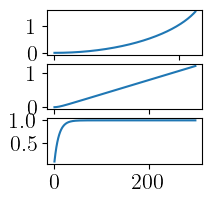

In [4]:
dt = 0.01
N = 300

# Systems
system = AckermannVelDelay(dt)
system.state = np.zeros(4)
state_list = []
state_perturb_list = []

for i in range(N):
    action = np.array([1.0, 0.2])
    result = system.step(action)
    state_list.append(system.state)
    
fig, ax = plt.subplots(3, 1, figsize=(2, 2))
state_list = np.array(state_list)
ax[0].plot(state_list[:, 0], state_list[:, 1], '-')
ax[1].plot(state_list[:, 2], '-', label='theta')    
ax[2].plot(state_list[:, 3], '-', label='v_x')    


# Test the expert controller

-0.08461213556940628
period 85.82046841925836 length 28.606822806419455
omega_des 0.0 theta_des -0.08461213556940628 theta_des_prev -0.08461213556940628
initial system state [ 0.          0.         -0.08461214  2.96192196]
result (array([ 2.95132577e-02, -2.50315616e-03, -8.46121356e-02,  2.96192196e+00]), -0.0, False, False)


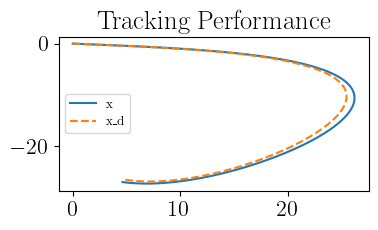

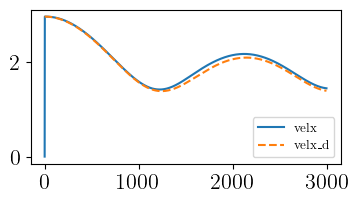

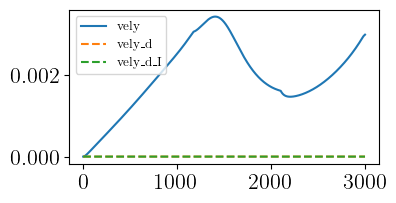

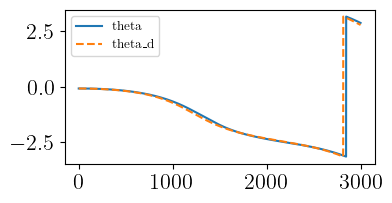

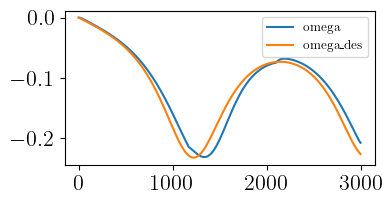

In [5]:
dt = 0.01
N = 3000

STATE_IDX_POS_X = 0
STATE_IDX_POS_Y = 1
STATE_IDX_HEADING = 2

system = AckermannVelDelay(dt)


def desired_trajectory(N, dt):
    '''
    Returns the desired trajectory for the system. [N x 6]
    '''

    angle_start = np.random.uniform(-np.pi, np.pi)
    print(angle_start)
    x0 = np.array([0.0, 0.0, angle_start])
    length = np.random.uniform(10, 30)
    period = 3*length
    print('period', period, 'length', length)
    theta_des_prev = angle_start
    x_vec_d = np.zeros((N, 6))
    t = np.arange(0, N*dt, dt)
    for i, tt in enumerate(t):
        x = compute_fig8_simple(period, length, tt, x0)
        x_I, y_I, z_I, vx_I, vy_I, vz_I = x
        theta_des = wrap_circular_value(np.arctan2(vy_I, vx_I))
        omega_des = wrap_circular_value((theta_des - theta_des_prev))/dt
        if i == 0:
            print('omega_des', omega_des, 'theta_des', theta_des, 'theta_des_prev', theta_des_prev)
        theta_des_prev = theta_des

        v_des_I = np.array([vx_I, vy_I])
        R_des = np.array([[np.cos(theta_des), -np.sin(theta_des)],
                          [np.sin(theta_des), np.cos(theta_des)]])
        v_des_B = R_des.T @ v_des_I
        
        x_vec_d[i, 0:2] = np.array([x_I, y_I])
        x_vec_d[i, 2] = theta_des
        x_vec_d[i, 3:5] = v_des_B
        x_vec_d[i, 5] = omega_des
    return x_vec_d

state_list = []
vel_list = []
vel_des_list = []
des_traj_list = []
expert_policy = ExpertPolicy(dt)
x_I_prev = np.zeros(2)
theta_prev = 0
x_d = desired_trajectory(N, dt)

system.state = x_d[0, 0:4].copy()

print('initial system state', system.state)
obs_k = system.state.copy()
obs_k_prev = system.state.copy()

for i in range(N):
    x_updated, xd_updated = states_2_control_states(obs_k_prev, obs_k, x_d[i, :], dt)
    obs_k_prev = obs_k.copy()
    state_list.append(system.state)
    des_traj_list.append(x_d[i, 0:3])
    vel_des_list.append(xd_updated[3:6])
    vel_list.append(x_updated[3:6])
    policy = expert_policy(x_updated, xd_updated)
    result = system.step(policy)
    if i == 0:
        print('result', result)
    obs_k = result[0].copy()

    x_I_prev = obs_k[0:2].copy()
    theta_prev = obs_k[2].copy()
    

state_list = np.array(state_list)
des_traj_list = np.array(des_traj_list)
vel_list = np.array(vel_list)
vel_des_list = np.array(vel_des_list)

fig, ax = plt.subplots(1, 1, figsize=(4, 2))
ax.set_title('Tracking Performance')
ax.plot(state_list[:, 0], state_list[:, 1], '-', label='x')
ax.plot(x_d[:, 0], x_d[:, 1], '--', label='x_d')
ax.legend(fontsize='xx-small')

fig, ax = plt.subplots(1, 1, figsize=(4, 2))
ax.plot(vel_list[:, 0], '-', label='velx')
ax.plot(vel_des_list[:, 0], '--', label='velx_d')
ax.legend(fontsize='xx-small')

fig, ax = plt.subplots(1, 1, figsize=(4, 2))
ax.plot(vel_list[:, 1], '-', label='vely')
ax.plot(vel_des_list[:, 1], '--', label='vely_d')
ax.plot(x_d[:, 4], '--', label='vely_d_I')
ax.legend(fontsize='xx-small')

fig, ax = plt.subplots(1, 1, figsize=(4, 2))
ax.plot(state_list[:, 2], '-', label='theta')
ax.plot(x_d[:, 2], '--', label='theta_d')
ax.legend(fontsize='xx-small')

fig, ax = plt.subplots(1, 1, figsize=(4, 2))
ax.plot(vel_list[:, 2], '-', label='omega')
ax.plot(vel_des_list[:, 2], '-', label='omega_des')
ax.legend(fontsize='xx-small')



# Train Dagger

In [6]:
from nnpolicy import NNPolicy
from DAgger import DAgger

In [7]:
input_size_NN = 12
limits = [2, 0.5]
net_arch = [(input_size_NN, 48), (48, 84), (84, 48), (48, 2)] # NN policy
policy = NNPolicy(net_arch, limits)

In [8]:
epochs = 4
dagger_trainer = DAgger(
    system, expert_policy, policy, desired_trajectory, np.linspace(1, 0, epochs), 8000, None, 4, input_size_NN
    )

-0.46385878766710986
period 75.22721302533958 length 25.075737675113196
omega_des 0.0 theta_des -0.46385878766710986 theta_des_prev -0.46385878766710986
-0.4502603676280348
period 60.901139417064186 length 20.300379805688063
omega_des 0.0 theta_des -0.4502603676280348 theta_des_prev -0.4502603676280348
1.5843107129332665
period 83.5059374546474 length 27.835312484882465
omega_des 0.0 theta_des 1.5843107129332665 theta_des_prev 1.5843107129332665
-2.798635936564402
period 41.45383839959501 length 13.817946133198335
omega_des 0.0 theta_des -2.798635936564402 theta_des_prev -2.798635936564402
Loss: 2.6952607186103705e-06
-1.7617554055110758
period 75.6842600393691 length 25.228086679789698
omega_des 0.0 theta_des -1.7617554055110758 theta_des_prev -1.7617554055110758
-1.1392563010074745
period 30.019291155531683 length 10.006430385177227
omega_des 0.0 theta_des -1.1392563010074745 theta_des_prev -1.1392563010074745
1.51314141658652
period 71.97434746492353 length 23.991449154974507
omega_

/Users/sorinalupu/CaltechResearch/biped/code/biped_ros2/src/biped/imit_learning/DAgger.py:157: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1, figsize=(5, 5))


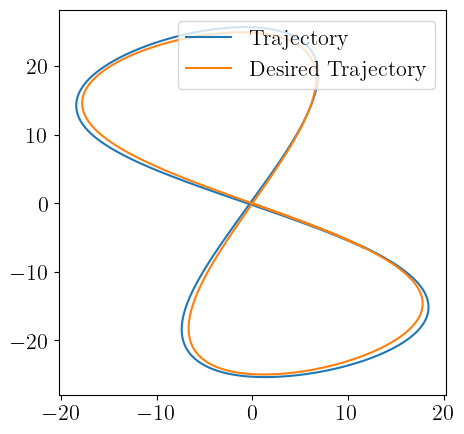

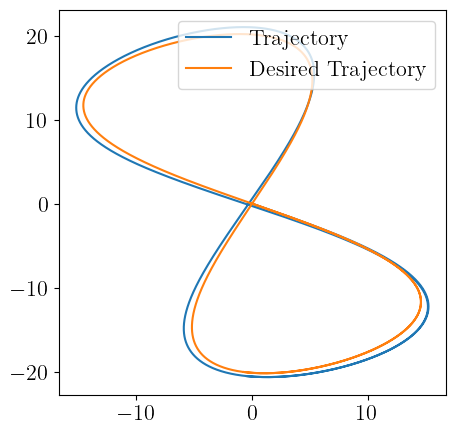

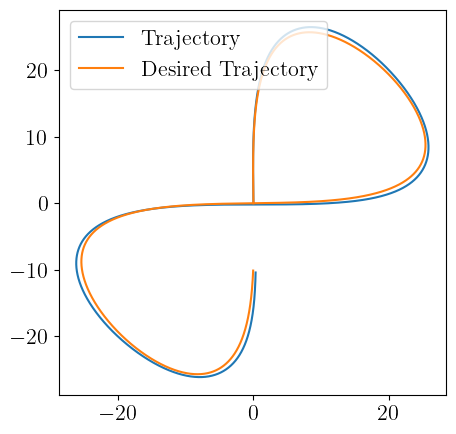

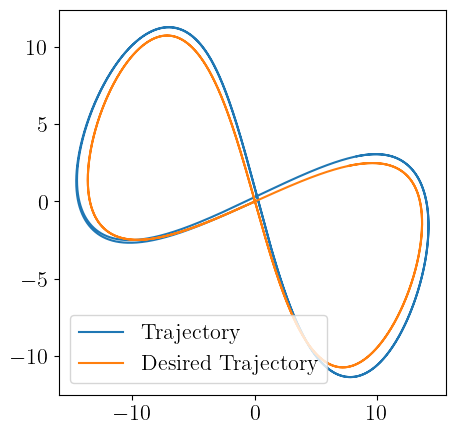

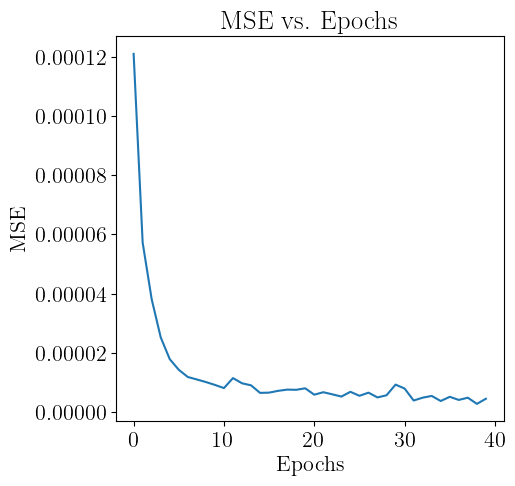

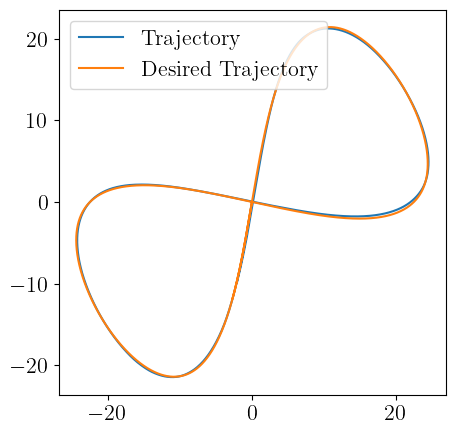

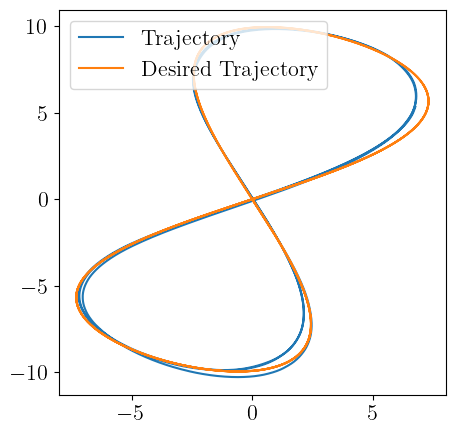

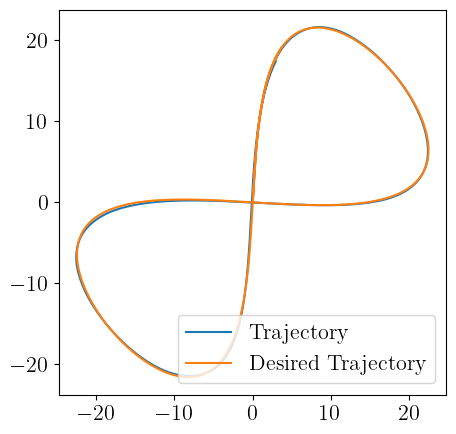

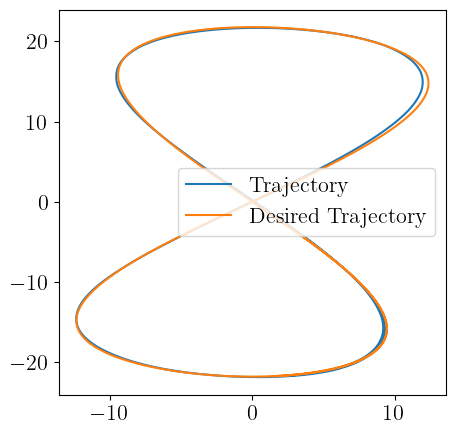

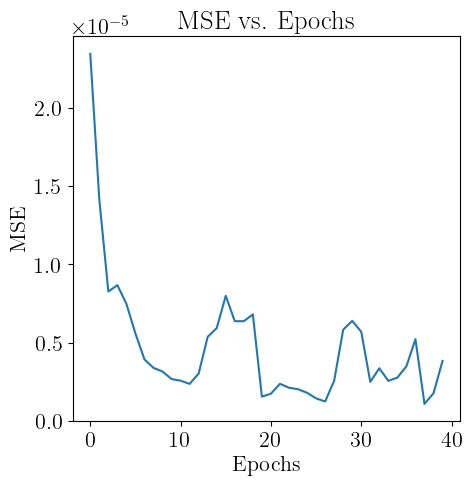

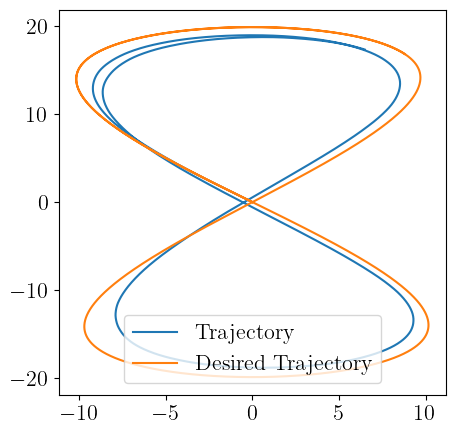

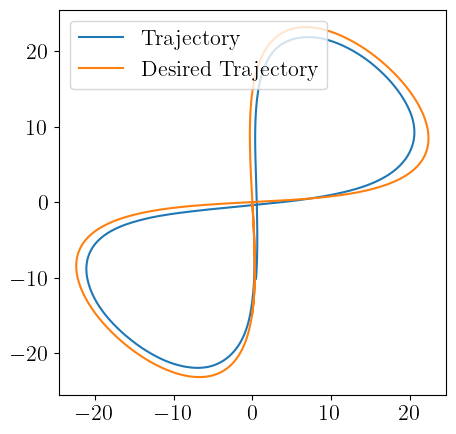

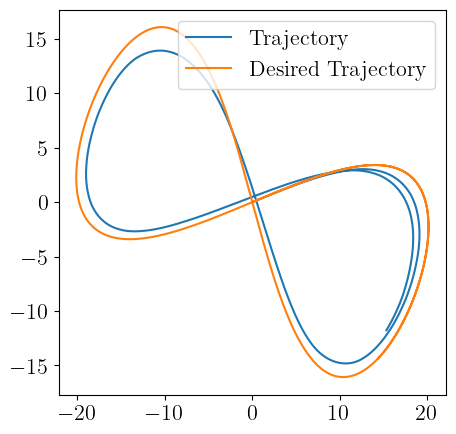

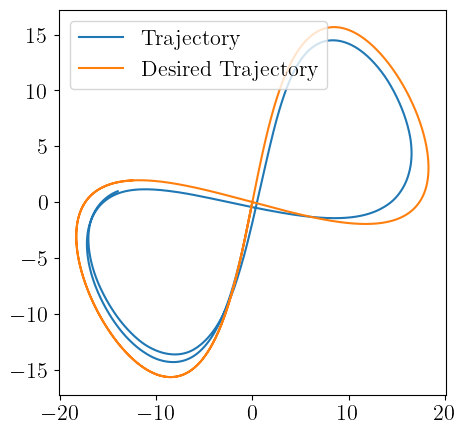

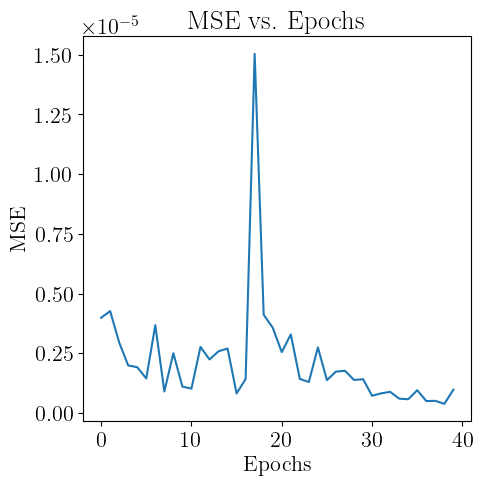

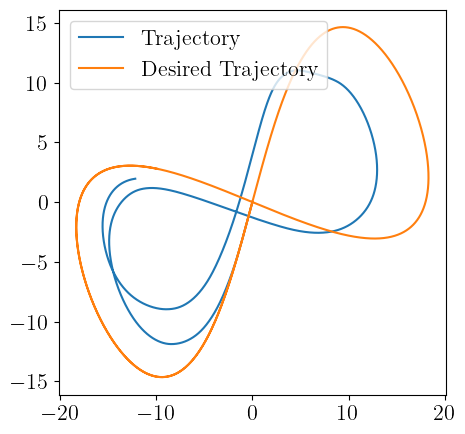

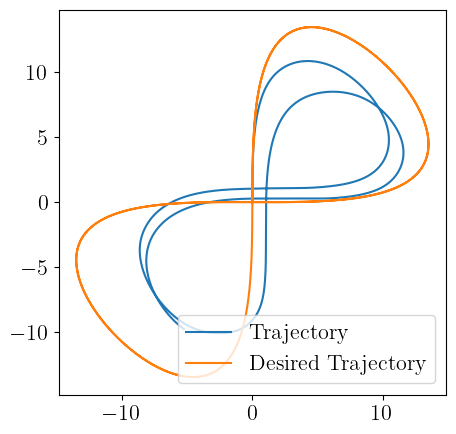

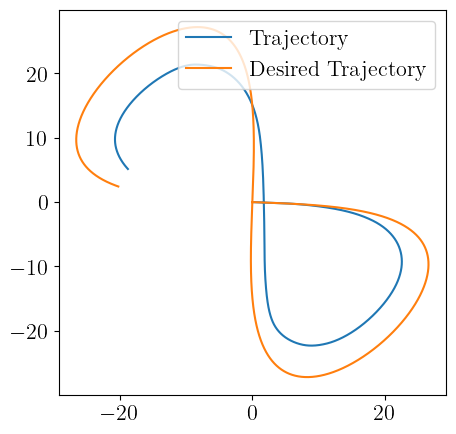

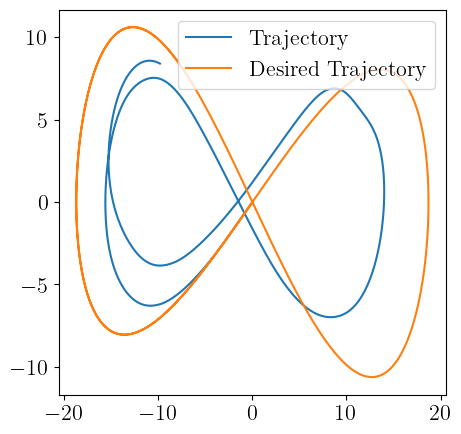

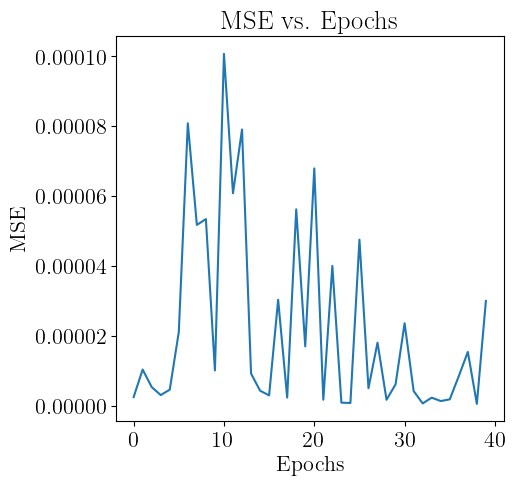

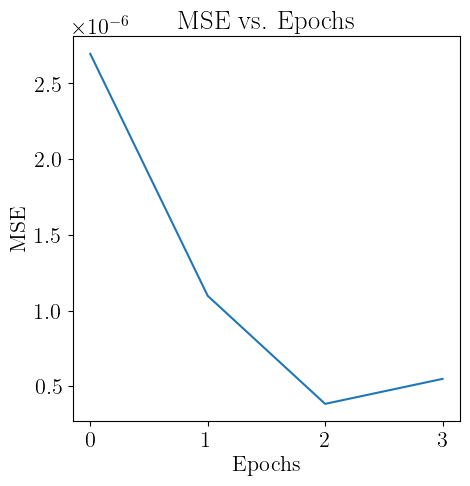

In [9]:
import torch

train = True
if train == True:
    dagger_trainer.train_dagger(epochs)


In [10]:
# # Multiple traj regulation:
def multiple_traj_reg(sys, sys_name, policy, use_NN=False):
    nb_traj = 1
    _, ax = plt.subplots(1, 1, figsize=(2, 2), gridspec_kw={'hspace': 0.5})
    for i in range(nb_traj):
        sys.reset()
        N = 10000
        
        x_d_B = desired_trajectory(N, dt)
        
        sys.state = x_d_B[0, 0:4].copy()
        obs_k = sys.state.copy()
        obs_k_prev = sys.state.copy()
        state_list = []
        action_list = []
        for i in range(N):
            x, x_d_modified = states_2_control_states(obs_k_prev, obs_k, x_d_B[i, :], dt)
            obs_k_prev = obs_k.copy()
            action = policy(x, x_d_modified)
            result = sys.step(action.squeeze())
            obs_k = result[0]
            action_list.append(action.squeeze())

            state_list.append(np.array([sys.state[0], system.state[1], sys.state[2], x[3], x[4], x[5]]))
            
        state_list = np.array(state_list)
        # equal axis
        ax.plot(state_list[:, 0], state_list[:, 1], '-', label='x')
        ax.plot(x_d_B[:, 0], x_d_B[:, 1], '--', label='x_d')
        ax.set_title(sys_name, fontsize='xx-small')
        ax.legend(fontsize='xx-small')
        ax.set_aspect('equal', 'box')
        
        _, ax = plt.subplots(6, 1, figsize=(10, 10), gridspec_kw={'hspace': 0.5})

        ax[0].plot(state_list[:, 2], '-', label='theta')
        ax[0].plot(x_d_B[:, 2], '--', label='theta_d')
        ax[0].set_xticklabels([])
        
        ax[1].plot(state_list[:, 3], '-', label='v_x')
        ax[1].plot(x_d_B[:, 3], '--', label='v_x_d')
        ax[1].set_xticklabels([])

        ax[2].plot(state_list[:, 4], '-', label='v_y')
        ax[2].plot(x_d_B[:, 4], '--', label='v_y_d')
        ax[2].set_xticklabels([])

        ax[3].plot(state_list[:, 5], '-', label='omega')
        ax[3].plot(x_d_B[:, 5], '--', label='omega_d')
        
        action_list = np.array(action_list)
        ax[4].plot(action_list[:, 0], '-', label='u_x')
        ax[5].plot(np.rad2deg(action_list[:, 1]), '-', label='u_steering')

-1.180731003223271
period 45.32421176807003 length 15.108070589356677
omega_des 0.0 theta_des -1.180731003223271 theta_des_prev -1.180731003223271
-2.524348328882233
period 61.38886527730588 length 20.462955092435294
omega_des 0.0 theta_des -2.524348328882233 theta_des_prev -2.524348328882233


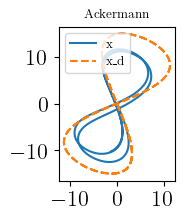

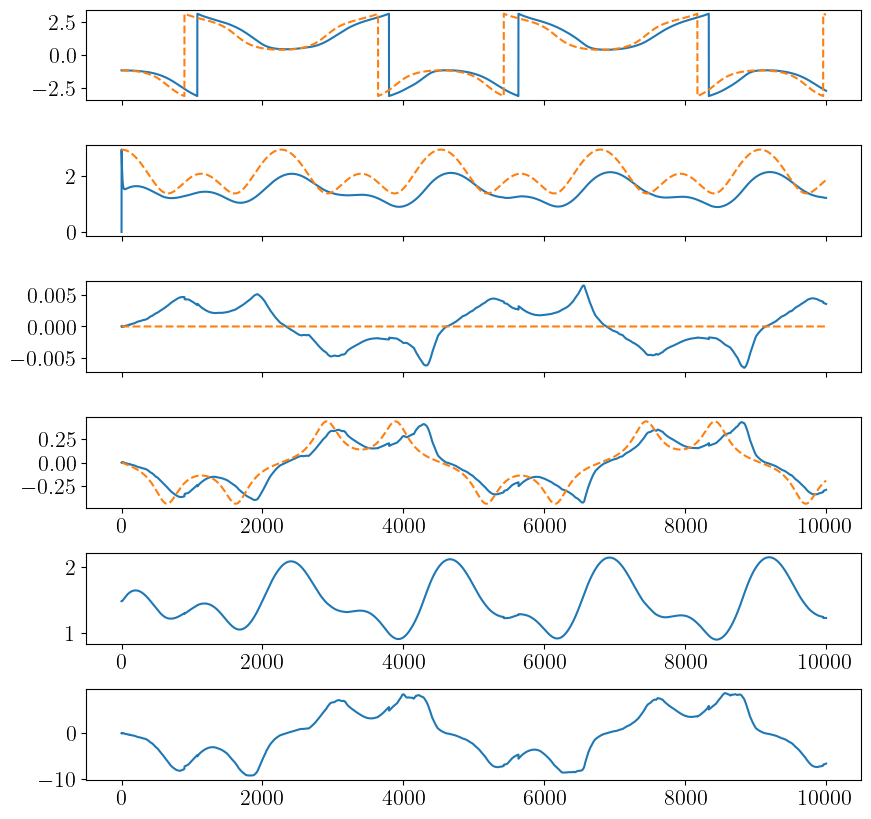

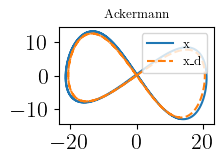

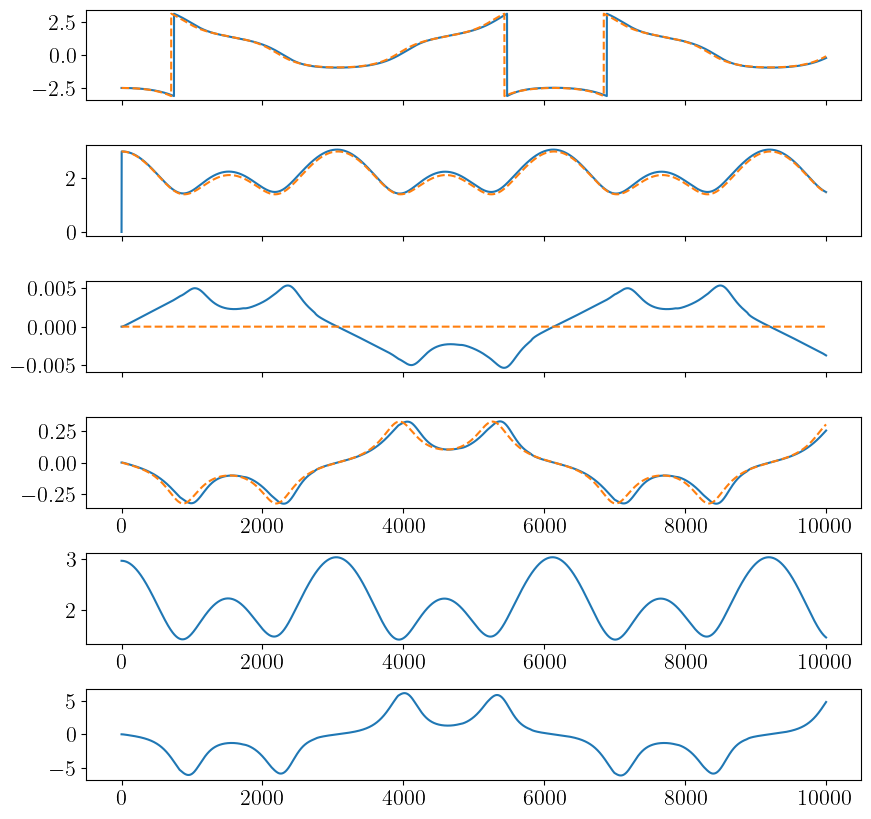

In [11]:
# Evaluate
import mlpfile
import mlpfile.torch

weights = torch.load('models/model_weights.pth')
policy.load_state_dict(weights)
mlpfile.torch.write(policy.model, 'models/model_weights.mlp')
policy_mlp = mlpfile.Model.load("models/model_weights.mlp")

system = AckermannVelDelay(dt)

def policy_NN(x, x_des):
    input_NN = np.concatenate([x, x_des])
    return policy_mlp.forward(input_NN)

multiple_traj_reg(system, sys_name='Ackermann', policy=policy_NN, use_NN=True)
multiple_traj_reg(system, sys_name='Ackermann', policy=expert_policy)
